In [1]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
TEST_DIR = r"D:\Major Project\Final Proper\Centralized dataset\Centralized_Balanced\test"

In [2]:
import socket
import struct
import zlib
import tempfile
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import layers, initializers, backend as K
from sklearn.metrics import confusion_matrix, accuracy_score
from cryptography.fernet import Fernet
import base64
import hashlib

In [3]:
# Custom Capsule Network Components
@register_keras_serializable(package="Custom")
class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]
    
    def get_config(self):
        return super(Length, self).get_config()

@tf.keras.saving.register_keras_serializable(package="Custom")
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super().__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        self.W = self.add_weight(
            shape=[1, self.input_num_capsule, self.num_capsule, self.dim_capsule, self.input_dim_capsule],
            initializer=initializers.glorot_uniform(),
            name='W'
        )
        self.built = True

    def call(self, inputs):
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)
        W_tiled = K.tile(self.W, [K.shape(inputs)[0], 1, 1, 1, 1])
        inputs_hat = tf.squeeze(tf.matmul(W_tiled, inputs_expand, transpose_b=True), axis=-1)
        b = tf.zeros(shape=[K.shape(inputs)[0], self.input_num_capsule, self.num_capsule])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            c_expand = K.expand_dims(c, -1)
            outputs = self.squash(tf.reduce_sum(inputs_hat * c_expand, axis=1))
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * K.expand_dims(c, -1), axis=-1)
        
        return outputs
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_capsule": self.num_capsule,
            "dim_capsule": self.dim_capsule,
            "routings": self.routings
        })
        return config
    def squash(self, vectors, axis=-1):
        s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
        return scale * vectors

@tf.keras.saving.register_keras_serializable(package="Custom", name="margin_loss")
def margin_loss(y_true, y_pred):
    # Remove explicit one-hot conversion if labels are already categorical
    if len(y_true.shape) == 2:  # Already one-hot encoded
        y_true_ = y_true
    else:  # Convert sparse labels to one-hot
        y_true_ = tf.one_hot(tf.cast(y_true, tf.int32), depth=2)
    
    L = y_true_ * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true_) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))


class MobileNetCapsNet:
    def __init__(self, input_shape=(224, 224, 3)):
        self.input_shape = input_shape
        self.model = self._build_model()
    
    def _build_model(self):
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=self.input_shape,
            include_top=False,
            weights='imagenet'
        )
        base_model.trainable = False
        
        x = base_model.output
        x = layers.Conv2D(256, 3, activation='relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Reshape((-1, 256))(x)
        
        x = CapsuleLayer(num_capsule=8, dim_capsule=16, routings=3)(x)
        x = CapsuleLayer(num_capsule=2, dim_capsule=32, routings=3)(x)
        outputs = Length()(x)
        
        return tf.keras.Model(inputs=base_model.input, outputs=outputs)
    
    def compile_model(self, learning_rate=0.001):
        """Compile the model with appropriate loss and optimizer"""
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        self.model.compile(
            optimizer=optimizer,
            loss=self.margin_loss,
            metrics=['accuracy']
        )
        
    @staticmethod
    def margin_loss(y_true, y_pred):
        """Margin loss for capsule network"""
        # Convert y_true to one-hot if it isn't already
        if len(K.int_shape(y_true)) == 1:
            y_true = tf.one_hot(tf.cast(y_true, 'int32'), 2)
            
        L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
            0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
        return tf.reduce_mean(tf.reduce_sum(L, axis=1))


In [8]:
from tensorflow.keras.models import load_model
def load_model_from_file():
    return load_model(r"D:\Major Project\Final Proper\Models\drowsiness_model_With_balanced_lesser.keras", 
                      custom_objects={"CapsuleLayer": CapsuleLayer,"Length":Length,"margin_loss":margin_loss})

In [19]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
def evaluate_model_old(model, dataset_dir):
# Define test image generator
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    class_labels=['Eyeclose','Neutral', 'Yawn']
    # Load test images
    test_gen = test_datagen.flow_from_directory(
        dataset_dir,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',  
        color_mode='rgb',
        shuffle=False
    )
    # Get predictions (probabilities)
    # Get predictions (probabilities)
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    y_true = test_gen.classes
    plot_confusion_matrix(y_true, y_pred, class_labels)
    print("\nTest Metrics:")
    print(f"Accuracy: {np.mean(y_true == y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))

In [21]:
global_model = load_model_from_file()

Found 742 images belonging to 3 classes.


D:\Major Project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step


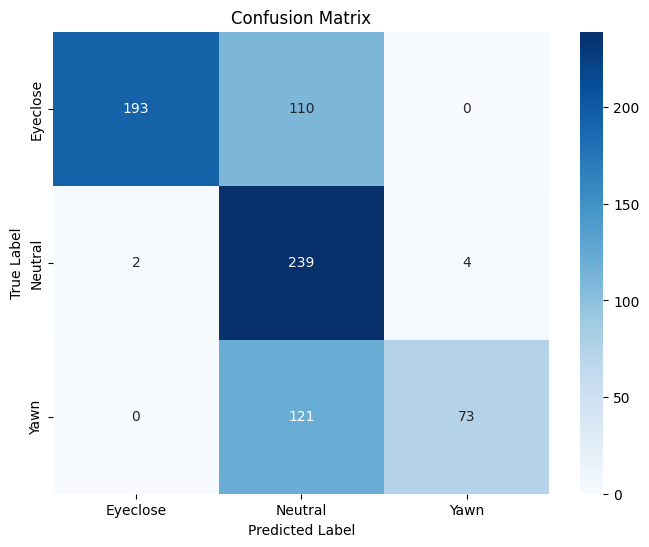


Test Metrics:
Accuracy: 0.6806

Classification Report:
              precision    recall  f1-score   support

    Eyeclose       0.99      0.64      0.78       303
     Neutral       0.51      0.98      0.67       245
        Yawn       0.95      0.38      0.54       194

    accuracy                           0.68       742
   macro avg       0.82      0.66      0.66       742
weighted avg       0.82      0.68      0.68       742



In [22]:
evaluate_model_old(global_model, r"D:\Major Project\Final Proper\Centralized dataset\Centralized_Balanced\test")

In [12]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Dataset directory
DATASET_DIR = "D:\Major Project\Final Proper\Centralized dataset\Centralized_Balanced"
LEARNING_RATE = 0.001
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 8
EPOCHS = 5
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [13]:
def train_incremental_model():
    rounds = sorted([os.path.join(DATASET_DIR, d) for d in os.listdir(DATASET_DIR) if d.startswith("set")])
    
    model = global_model  # Ensure MobileNetCapsNet is defined
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
        loss=margin_loss,  # Ensure margin_loss is defined
        metrics=['accuracy']
    )

    for i, round_dir in enumerate(rounds):
        print(f"\nTraining on {round_dir} (Round {i+1}/{len(rounds)})")

        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    validation_split=0.2,        
                )
        train_flow = datagen.flow_from_directory(
            round_dir,
            target_size=INPUT_SHAPE[:2],
            batch_size=BATCH_SIZE,
            class_mode='categorical',  # Change from 'binary' to 'categorical'
            color_mode='rgb',
            subset='training',
            shuffle=True 
        )
    
        val_flow = datagen.flow_from_directory(
            round_dir,
            target_size=INPUT_SHAPE[:2],
            batch_size=BATCH_SIZE,
            class_mode='categorical',  # Change from 'binary' to 'categorical'
            color_mode='rgb',
            subset='validation'
        )

        model.fit(
            train_flow,
            validation_data=val_flow,
            epochs=EPOCHS,
            verbose=1
        )

        # After training on each round, evaluate the model
        print(f"\nEvaluating after training Set {i+1}")
        test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        test_gen = test_datagen.flow_from_directory(
            TEST_DIR,
            target_size=INPUT_SHAPE[:2],
            batch_size=BATCH_SIZE,
            class_mode='categorical',  # Change from 'binary' to 'categorical'
            color_mode='rgb',
            shuffle=False
        )
        # Get predictions (probabilities)
        # Get predictions (probabilities)
        # Get predictions (probabilities)
        y_pred = np.argmax(model.predict(test_gen), axis=1)
        y_true = test_gen.classes
    
        print("\nTest Metrics:")
        print(f"Accuracy: {np.mean(y_true == y_pred):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=['Eyeclose','Neutral', 'Yawn'], zero_division=0))
        class_labels=['Eyeclose','Neutral', 'Yawn']
        # Plot confusion matrix
        plot_confusion_matrix(y_true, y_pred, class_labels)


Training on D:\Major Project\Final Proper\Centralized dataset\Centralized_Balanced\set1 (Round 1/3)
Found 576 images belonging to 3 classes.
Found 143 images belonging to 3 classes.


D:\Major Project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 321ms/step - accuracy: 0.7646 - loss: 0.1617 - val_accuracy: 0.4126 - val_loss: 0.4058
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.8125 - loss: 0.1226 - val_accuracy: 0.4126 - val_loss: 0.4438
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 0.8651 - loss: 0.1100 - val_accuracy: 0.4545 - val_loss: 0.3685
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.8596 - loss: 0.0983 - val_accuracy: 0.4336 - val_loss: 0.4222
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.8851 - loss: 0.0936 - val_accuracy: 0.4266 - val_loss: 0.4639

Evaluating after training Set 1
Found 742 images belonging to 3 classes.
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step

Test Metrics:
Accuracy: 0.7358

Classification Report:
              precision    recall  f1-score   support

    Eyeclose       1.00      0.71      0.83       303
     Neutral       0.56      0.98      0.71       245
        Yawn       0.90  

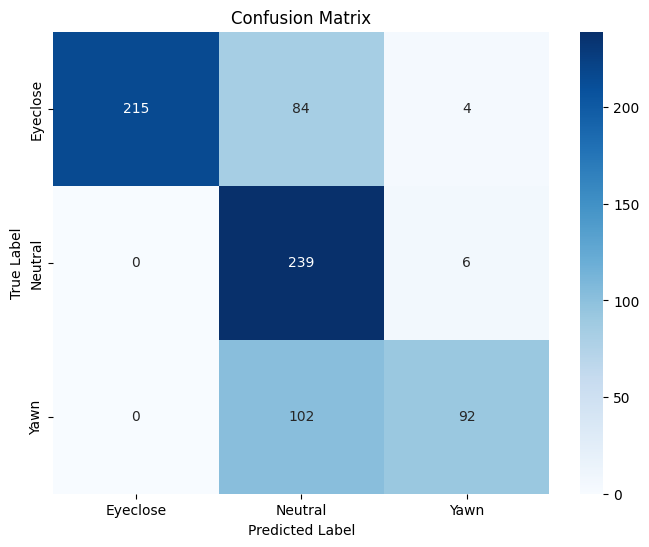


Training on D:\Major Project\Final Proper\Centralized dataset\Centralized_Balanced\set2 (Round 2/3)
Found 574 images belonging to 3 classes.
Found 143 images belonging to 3 classes.


D:\Major Project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - accuracy: 0.8402 - loss: 0.1223 - val_accuracy: 0.4056 - val_loss: 0.4528
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 241ms/step - accuracy: 0.8874 - loss: 0.0985 - val_accuracy: 0.4126 - val_loss: 0.4658
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.8566 - loss: 0.0983 - val_accuracy: 0.4056 - val_loss: 0.4001
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.8534 - loss: 0.1033 - val_accuracy: 0.4336 - val_loss: 0.4193
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.8965 - loss: 0.0864 - val_accuracy: 0.4056 - val_loss: 0.4346

Evaluating after training Set 2
Found 742 images belonging to 3 classes.
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step

Test Metrics:
Accuracy: 0.7709

Classification Report:
              precision    recall  f1-score   support

    Eyeclose       0.99      0.75      0.86       303
     Neutral       0.60      0.92      0.73       245
        Yawn       0.86  

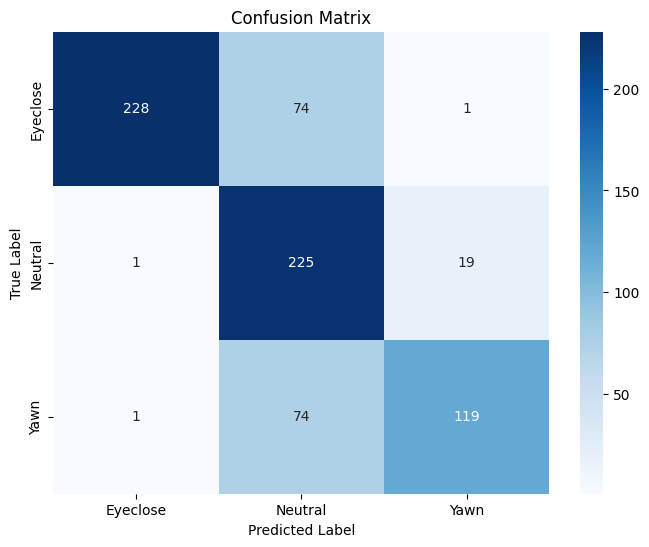


Training on D:\Major Project\Final Proper\Centralized dataset\Centralized_Balanced\set3 (Round 3/3)
Found 572 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


D:\Major Project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 290ms/step - accuracy: 0.8418 - loss: 0.1147 - val_accuracy: 0.4823 - val_loss: 0.3512
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.8685 - loss: 0.1004 - val_accuracy: 0.4681 - val_loss: 0.4359
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.8760 - loss: 0.0864 - val_accuracy: 0.4539 - val_loss: 0.4459
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 209ms/step - accuracy: 0.8894 - loss: 0.0912 - val_accuracy: 0.4468 - val_loss: 0.4236
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.8910 - loss: 0.0946 - val_accuracy: 0.4539 - val_loss: 0.4364

Evaluating after training Set 3
Found 742 images belonging to 3 classes.
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step

Test Metrics:
Accuracy: 0.7615

Classification Report:
              precision    recall  f1-score   support

    Eyeclose       1.00      0.70      0.83       303
     Neutral       0.60      0.94      0.73       245
        Yawn       0.84  

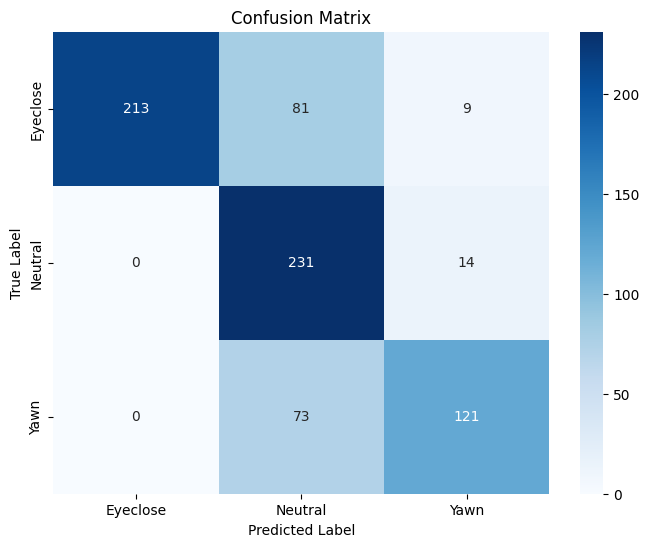

In [14]:
train_incremental_model()